In [1]:
# setup
import pandas as pd
import matplotlib.pyplot as plt

import MyFunctions as f

In [2]:
train = pd.read_csv("data/aps_failure_training_set.csv")
test = pd.read_csv("data/aps_failure_test_set.csv")

# basic prepocessing
"""format classes as pos: 1, neg: 0
convert na in NaN values"""
train = f.data_prepro(train)
test = f.data_prepro(test)

# null values
"""drop features with more than t% of NaN on the trainset
fill the remaining nulls with the mean of the column"""
[y_train, X_train, y_test, X_test] = f.null_values(train, test, t=0.5)

In [3]:
# standarization
from sklearn.preprocessing import RobustScaler

def standardize(X_train, X_test):
    transformer = RobustScaler().fit(X_train)
    
    X_trainS = transformer.transform(X_train)
    X_testS = transformer.transform(X_test)
    
    X_trainS = pd.DataFrame(data = X_trainS, columns = X_train.columns)
    X_testS = pd.DataFrame(data = X_testS, columns = X_test.columns)
    return X_trainS, X_testS

In [4]:
X_train, X_test = standardize(X_train, X_test)

### Feature Selection

In [5]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
import numpy as np
import seaborn as sns

In [6]:
def feature_selection_with_plots(X_train, y_train):
    # initial point
    print("Current N of features:", len(X_train.columns))
    print(" ")

    # removing features with zero variance
    print("\033[1m" + "Remove features with zero variance" + "\033[0m")
    selector = VarianceThreshold()
    selector.fit_transform(X_train)
    selected_columns = X_train.columns[(selector.get_support())]
    print("N of dropped columns:", len(set(X_train.columns) - set(selected_columns)))

    X_train = X_train[selected_columns]
    print("Current N of features:", len(X_train.columns))

    # Tree-based feature selection
    clf = ExtraTreesClassifier(n_estimators=50, random_state=333)
    clf = clf.fit(X_train, y_train)

    # feature importance
    feature_importance = clf.feature_importances_.ravel()
    feature_names = X_train.columns
    data_tuples = list(zip(feature_names, feature_importance))
    features = pd.DataFrame(data_tuples, columns=["feature_names", "feature_importance"])

    # plot top n features sorted by feature importance
    n = 30
    fe = features.sort_values(["feature_importance"], ascending=False).reset_index(drop=True)
    fe = fe.head(n)
    fe = fe.sort_values(["feature_importance"], ascending=True).reset_index(drop=True)

    fig = plt.figure(figsize = [12,7])
    ax = fig.add_axes([0,0,1,1])

    data = fe["feature_importance"].values
    names = fe["feature_names"].values
    y_pos = np.arange(len(names))

    plt.barh(y_pos, data, color = "darkgreen")
    plt.yticks(y_pos, names)

    plt.title("Top "+str(n)+ " features")
    plt.xlabel("feature importance")
    plt.ylabel("column name")
    plt.savefig("figures/Top"+str(n)+ "features.png", bbox_inches = "tight")
    plt.show()
    
    print("\033[1m" + "Tree-based feature selection" + "\033[0m")
    selector = SelectFromModel(clf, prefit=True)
    selected_columns = X_train.columns[(selector.get_support())]
    print("N of dropped columns:", len(set(X_train.columns) - set(selected_columns)))

    X_train = X_train[selected_columns]
    print("Current N of features:", len(X_train.columns))

    corr = abs(X_train.corr())

    plt.figure(figsize=(12,12))
    sns.heatmap(corr, square = True)
    plt.title("Correlation Matrix after tree-based feature selection", fontsize = 15)
    plt.savefig("figures/cm_after_1stFS.png", bbox_inches = "tight")
    plt.show()
    
    # drop columns highly correlated between each-other and choose the one with higher feature importance
    print("\033[1m" + "Drop highly correlated features" + "\033[0m")
    correlations = []
    feature_tuples = []
    for col in X_train.columns:
        for row in X_train.columns:
            correlation = corr.loc[row, col]
            if row == col:
                pass
            elif (col, row) in feature_tuples:
                pass
            elif correlation >= 0.7:
                correlations.append(correlation)
                feature_tuples.append((row, col))

    drop = []
    for tup in feature_tuples:
        f0 = tup[0]
        f1 = tup[1]
        imp_f0 = features[features["feature_names"] == f0]["feature_importance"].values
        imp_f1 = features[features["feature_names"] == f1]["feature_importance"].values
        if imp_f0 <= imp_f1:
            drop.append(f0)
        else:
            drop.append(f1)
    drop = set(drop)

    print("N of dropped features:", len(drop))

    selected_columns = list(set(X_train.columns) - set(drop))
    X_train = X_train[selected_columns]

    print("Current N of features:", len(X_train.columns))

    corr = abs(X_train.corr())
    plt.figure(figsize=(12,12))
    sns.heatmap(corr, square = True, annot = True, fmt = ".2")
    plt.title("Final Correlation Matrix", fontsize = 15)
    plt.savefig("figures/cm_after_2ndFS.png", bbox_inches = "tight")
    plt.show()
    
    return X_train

Current N of features: 162
 
Remove features with zero variance
N of dropped columns: 1
Current N of features: 161


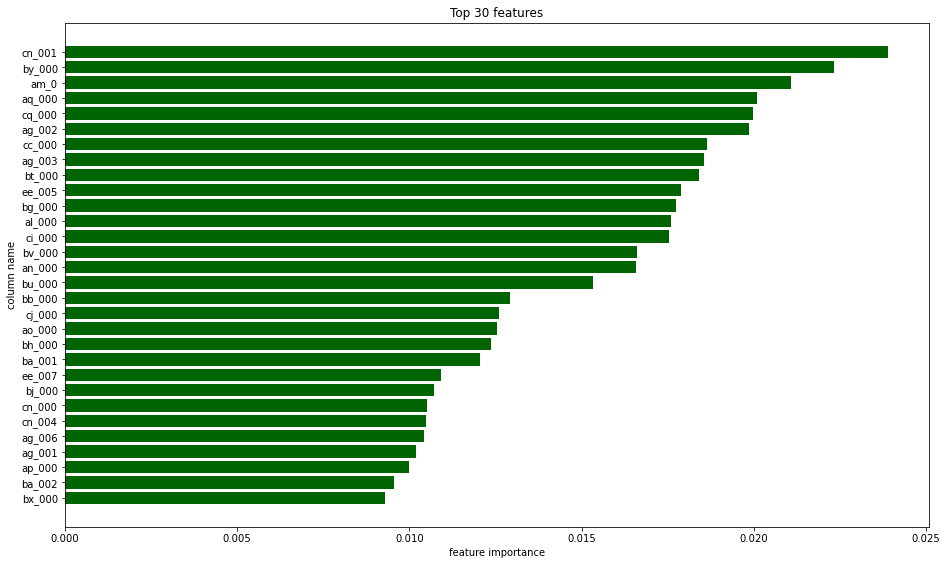

Tree-based feature selection
N of dropped columns: 110
Current N of features: 51


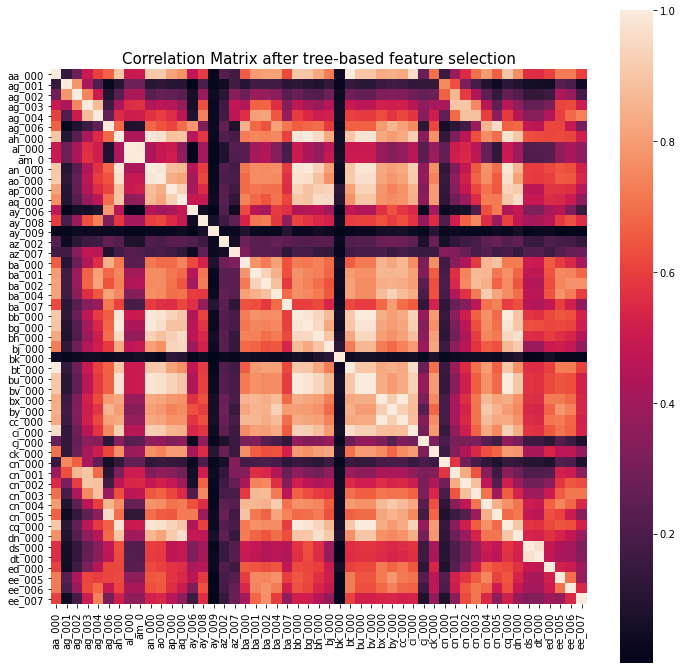

Drop highly correlated features
N of dropped features: 40
Current N of features: 11


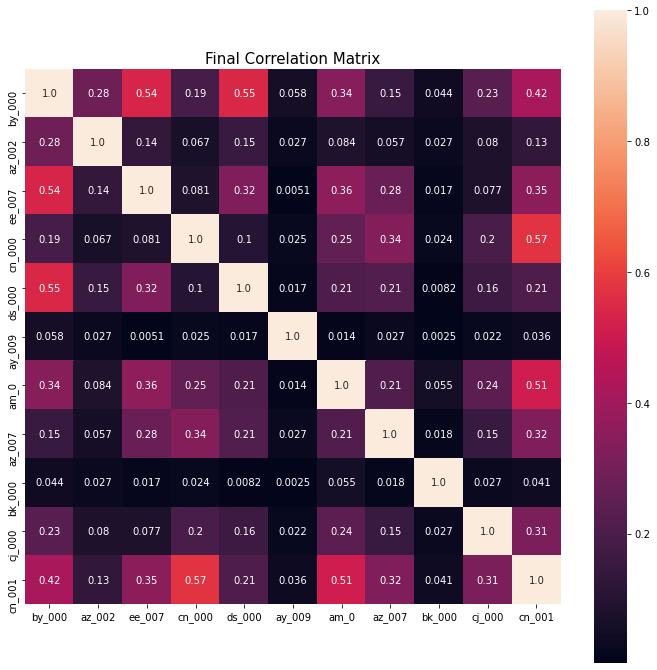

In [7]:
X_train = feature_selection_with_plots(X_train, y_train)

In [8]:
print(X_train.shape)
X_train.head()

(60000, 11)


,by_000,az_002,ee_007,cn_000,ds_000,ay_009,am_0,az_007,bk_000,cj_000,cn_001
0,1.545741,1.033356,0.702996,0.0,1.618391,0.0,0.000000,4.0,2.956308,0.0,0.0
1,0.255059,4.256171,0.240885,0.0,0.579199,0.0,0.000000,6.0,3.218708,0.0,0.0
2,0.140445,0.070714,0.703393,0.0,0.186465,0.0,0.000000,0.0,-1.809231,0.0,0.0
3,-0.629328,-0.336891,-0.247238,0.0,-0.500795,0.0,1.698953,1692.0,0.000000,0.0,52.0
4,0.607794,-0.151434,1.627050,0.0,1.061716,0.0,0.000000,0.0,2.366031,0.0,0.0


In [9]:
X_test = X_test[X_train.columns]
print(X_test.shape)
X_test.head()

(16000, 11)


,by_000,az_002,ee_007,cn_000,ds_000,ay_009,am_0,az_007,bk_000,cj_000,cn_001
0,-0.628229,-0.313542,-0.246709,0.0,-0.498871,2.0,1.035777,2948.0,0.016000,0.00,2.0
1,-0.627529,-0.322215,-0.244459,0.0,-0.499205,0.0,0.000000,0.0,0.016000,0.00,0.0
2,0.503522,0.048699,0.677273,0.0,0.645809,0.0,48.232112,123828.0,3.091200,0.00,5154.0
3,0.866300,0.136758,1.016528,0.0,0.895119,0.0,1.034904,0.0,-0.853169,38633.28,0.0
4,-0.612740,-0.318879,-0.244338,0.0,-0.482244,0.0,0.000000,0.0,0.016000,0.00,0.0
